# 3.8.1: Pennies Falling Redux

---

<br>

*Modeling and Simulation in Python*

Copyright 2021 Allen Downey, (License: [Creative Commons Attribution-NonCommercial-ShareAlike 4.0 International](https://creativecommons.org/licenses/by-nc-sa/4.0/))

Revised, Mike Augspurger (2021-present)

<br>

---

So far the differential equations we've worked with have been *first order*, which means they involve only first derivatives.  If the denominator of the equation is a $dt$, these can generally be seen as straight-forward rate equations.

<br>

In this notebook, we turn our attention to *second order* differential equations, which can involve both first and second derivatives.  We'll revisit the falling penny example we started the course with, and find the position and velocity of the penny as it falls, with and without air resistance.

## The Second Law of Motion as a Second Order DEQ

First order differential equations (DEs) can be written

<br>

$$\frac{dy}{dx} = G(x, y)$$

<br>

where $G$ is some function of $x$ and $y$.  If the denominator is $dt$, then we call these rate equations: how fast is some variable changing with time?  Second order DEs can be written

<br>

$$\frac{d^2y}{dx^2} = H(x, y)$$

<br>

where $H$ is a function of $x$ and $y$.  While a first order DE tells us how fast a variable is changing, a second order DE tells us how fast a *rate* is changing.  

What does that mean?  In this chapter, we will work with one of the most famous and useful second order DEs, the second law of motion:

<br>

$$\Sigma F = m a$$

<br>

where $\Sigma F$ is the sum of forces on an object, $m$ is the mass of the object, and $a$ is its acceleration.

<br>

<center>
<img src = https://github.com/MAugspurger/ModSimPy_MAugs/raw/main/Images_and_Data/Images/3_6/doohickeys.PNG width = 300>
</center>

<br>

True enough!  But let's see how it actually is a differential equation.  Start with velocity, which is a rate equation: the change in position with respect to time:

<br>

$$v = \frac{dy}{dt}$$

<br>

Now recognize that acceleration is the change in velocity with respect to time, and so another rate equation:

<br>

$$a = \frac{dv}{dt}$$

<br>

So acceleration is the rate of change of a rate: how fast is the rate of position changing with time:

<br>

$$a = \frac{\frac{dy}{dt}}{dt} = \frac{d^2y}{dt^2}$$

<br>

<center>
<img src = https://github.com/MAugspurger/ModSimPy_MAugs/raw/main/Images_and_Data/Images/3_6/doohickeys2.PNG width = 300>
</center>

<br>

Now we can rewrite the second law as a second order DEQ:

<br>

$$\frac{d^2y}{dt^2} = \Sigma F / m$$   

<br>

While velocity tells us how the variable *position* is changing with time, acceleration tells us how fast *velocity* is changing with time.  It is the rate of change of velocity, or more fundamentally, it is the rate of change of the rate of change of position (!).  That makes it a second order DE.

<br>

One last way to think about acceleration as a 2nd order derivative. Consider the metric base units for velocity ($\frac {m}{s}$) and acceleration ($\frac {m}{s^2}$).  The units for acceleration seem odd, but we can also write them like this:

$$\frac {\frac{m}{s}}{s}$$

This tells us that acceleration is in units of velocity per second: you can see that it is one rate (meters per second) "nested" inside another rate (velocity per second).

---

<br>

🟨 🟨 Active reading: Multiple choice


In [ ]:
import pandas as pd
import numpy as np
from urllib.request import urlretrieve

location = 'https://github.com/MAugspurger/ModSimPy_MAugs/raw/main/'
folder = 'Support_files/'
name = 'Embedded_Qs.ipynb'
local, _ = urlretrieve(location + folder + name, name)
%run /content/$name

#@title { run: "auto", form-width: "50%", display-mode: "form" }
home = 'https://github.com/MAugspurger/ModSimPy_MAugs/raw/main/Images_and_Data/Embedded_Qs/'
data = display_multC('3_6_2nd_order',home,0)
answer = "" # @param ["", "A", "B", "C", "D", "E"]
check_multC(data,answer)


---

## Dropping Pennies

As a first example, let's get back to the penny falling from the Empire State Building. We will implement two models of this system: first without air resistance, then with.

<br>

Given that the Empire State Building is 381 m high, and assuming that
the penny is dropped from a standstill, the inital state variables are the height and velocity.

In [24]:
import pandas as pd
import numpy as np

height = 381
state = pd.Series(dict(y=height, v=0))

We'll put our parameters in a system object: the magnitude of acceleration due to gravity, `g`, the time step `dt`, and the duration of the simulations, `t_end` (an arbitrary 10 seconds).

In [5]:
gravity = -9.8   # in m/s2
dt = 0.01       # in s
system = dict(g=gravity, t_end=10, dt=dt)

Now we need a change function, and here's where things get tricky. We can solve systems of first order DEs, but the second law is a second order DE.  How will we handle this?

<br>

We've got some tricks up our sleeve! Remember that both velocity and acceleration can be described as first order rate equations, as we saw above (rate of change of position, and rate of change of velocity).  And since velocity and acceleration depend on each other, we can rewrite the second law as a system of first order ODEs:

<br>

$$v= \frac{dy}{dt}  \qquad a= \frac{dv}{dt}$$

<br>

This set of equations embodies the idea we mentioned earlier: acceleration is the rate of change of the rate of change of position.

<br>

More concretely, this system allows us to translate the second law into a change function:

In [11]:
def change_func(t, state, system):
    y, v = state
    dt = system['dt']

    dydt = v
    dvdt = system['g']

    y = y + dydt*dt
    v = v + dvdt*dt

    return pd.Series(dict(y=y, v=v))

As usual, the parameters are the time step, a `state` object, and a `system` object.

* The first lines unpacks the state variables, `y` and `v`.

* The next two lines compute the derivatives of the state variables, `dydt` and `dvdt`.
The derivative of position is velocity, and the derivative of velocity is acceleration.
In this case, $a = g = -9.8$, which indicates that acceleration due to gravity is in the direction of decreasing $y$.

* The function multiplies `dydt` and `dvdt` by `dt` to get the total change in position and velocity for this time step and adds them to the old values for position and velocity.

* Finally, the function returns an updated state object.

Let's test the function with the initial conditions:

In [20]:
state = change_func(0, state, system)
state

y    380.96472
v     -0.88200
dtype: float64

You can run this multiple times and see that the penny is speeding up and losing height with each time step.  The time steps are very small, because we are trying to approximate a continuous differential equation: larger time steps would increase the *discretization error*.

<br>

Now we need a quick `run_simulation` function.  This is nearly identical to the function in the glucose notebooks:

In [28]:
def run_simulation(system, state, change_func):
    # Define the time steps
    t_array = np.arange(0, system['t_end']+1, system['dt'])
    n = len(t_array)

    # Set up a DataFrame to store the our state variables
    results = pd.DataFrame(index=t_array, columns=state.index,
                        dtype=np.float64)
    results.iloc[0] = state

    for i in range(n-1):
        t = t_array[i]
        state = change_func(t, state, system)
        # Save the state variables for this time step
        results.iloc[i+1] = state

    return results

`results` is a `DataFrame` with two columns: `y` contains the height of the penny; `v` contains its velocity.
Here are the first few rows.

In [41]:
# Run the simulation
state = pd.Series(dict(y=381, v=0))
results = run_simulation(system, state, change_func)
results.head()

,y,v
0.00,381.00000,0.000
0.01,381.00000,-0.098
0.02,380.99902,-0.196
0.03,380.99706,-0.294
0.04,380.99412,-0.392


We can plot the position results:

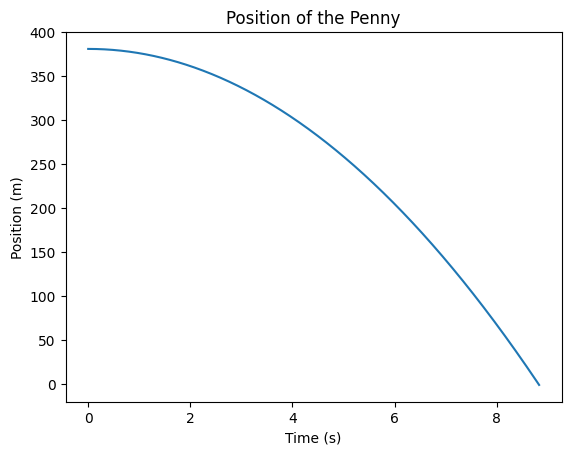

In [42]:
results.y.plot(xlabel='Time (s)',
         ylabel='Position (m)', title = 'Position of the Penny');

And the velocity results:

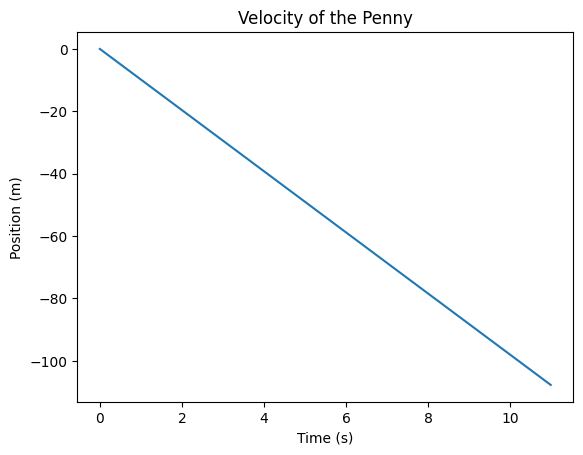

In [36]:
results.v.plot(xlabel='Time (s)',
         ylabel='Velocity (m/s)', title = 'Velocity of the Penny');

Since acceleration is constant, velocity magnitude increases linearly and position decreases quadratically (thus the parabolic shape of the position curve).  The last value of position is negative, which means we ran the simulation too long.

<br>

<center>
<img src = https://github.com/MAugspurger/ModSimPy_MAugs/raw/main/Images_and_Data/Images/3_6/pavement.PNG width = 300>
</center>

And yes, we still have to deal with the problem of drag don't we?  But let's stop the penny first.

---

<br>

🟨 🟨 Active reading: Multiple choice


In [ ]:
#@title { run: "auto", form-width: "50%", display-mode: "form" }
home = 'https://github.com/MAugspurger/ModSimPy_MAugs/raw/main/Images_and_Data/Embedded_Qs/'
data = display_multC('3_6_2nd_order',home,1)
answer = "" # @param ["", "A", "B", "C", "D", "E"]
check_multC(data,answer)


---

## Ending the simulation inside the for-loop

Let's try adding a clause to `run_simulation` that will stop the simulation when the penny hits the ground.



In [59]:
def run_simulation(system, state, change_func):
    # Define the time steps
    t_array = np.arange(0, system['t_end']+1, system['dt'])
    n = len(t_array)

    # Set up a DataFrame to store the our state variables
    results = pd.DataFrame(index=t_array, columns=state.index,
                        dtype=np.float64)
    results.iloc[0] = state

    for i in range(n-1):
        t = t_array[i]
        state = change_func(t, state, system)
        # Save the state variables for this time step
        results.iloc[i+1] = state
        # Test to see if the penny has hit the ground
        if state.y <= 0.0:
            results = results.dropna()
            return results

    return results

`dropna()` looks for any rows with a non-number value and removes those rows: this gets rid of the extra rows at the end of our DataFrame.  So let's create a refreshed state, and test the new iteration:

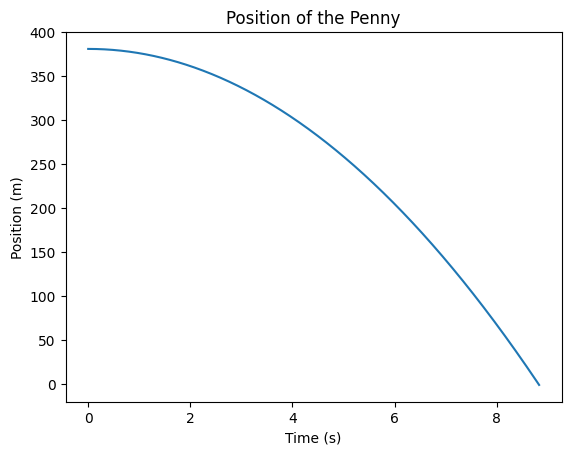

In [79]:
state = pd.Series(dict(y=381, v=0))
system = dict(g=gravity, t_end=10, dt=0.01)
results = run_simulation(system, state, change_func)
results.y.plot(xlabel='Time (s)',
         ylabel='Position (m)', title = 'Position of the Penny');


Easy peasy!   The simulation stops when the value of `y` reaches zero.  That means that the last set of values (`t`,`y`,`v`) for `results` will be the values when the penney hits the ground.  So we can get the flight time like this and final velocity like this:

In [80]:
print("The time of flight was", results.index[-1], "seconds")
print("The final velocity of the penny was", round(results.v.iloc[-1],3), "m/s")


The time of flight was 8.83 seconds
The final velocity of the penny was -86.534 m/s


Notice that there is some error here, because the penny did not stop exactly at `y = 0`:

In [81]:
results.y.iloc[-1]


-0.6149399999976994

A smaller `dt` would decrease this error, or we could use interpolation to get a more accurate time and velocity.  As it is, we know that our time value (8.83 s) is within one time step (0.1 s) of a more accurate answer.  That's probably good enough for us, considering that drag would make a much larger difference.

---

<br>

## Summary

In this chapter, we wrote the second law of motion, which is a second order DE, as a system of first order DEs.
Then we simulated a penny dropping from the Empire State Building in the absence of air resistance.

<br>

This is the same answer we got using the kinematic equation back in the first chapter, right?  So why is it better?  The answer is that we can add other forces to our equation, like air resistance, and get more realistic answers.

<br>

---

## Exercises

---

<br>

🟨 🟨

### Exercise 1

Take a moment and investigate the effect of time step size on our simulation.  The analytical solution from our first notebooks suggests that the analytical solution to this problem is that it takes 8.818 s for the penny to fall (with no drag).

* Make `dt` larger: find the largest `dt` (approximately) that will produce an error of less than 10% (that is, about 0.9 s).

* Make `dt` smaller: find the largest `dt` (approximately) that will produce an error of less than 0.1% (0.01 s).

Did you notice any difference in how long it takes the simulations to run?


✅ ✅ Put your answers here